# Example: MNIST with NICE

2020-11-18 first created

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from flow import NICE
from utils import *
import tensorflow as tf
mnist = tf.keras.datasets.mnist

print(tf.__version__)
!python --version

2.3.1
Python 3.7.6


## Settings

In [2]:
inp_dim = 784
n_couple_layer = 5
n_hid_layer = 5
n_hid_dim = 512
n_batch = 128
n_epoch = 10000
n_display = 1000

In [3]:
(x_train, y_train), (_, _) = mnist.load_data()

img_h, img_w = x_train.shape[1:]
inp_dim = img_h * img_w

x_train = x_train.reshape([-1, inp_dim]).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = tf.data.Dataset.zip((dataset, dataset))
dataset = dataset.repeat().shuffle(x_train.shape[0]).batch(n_batch, drop_remainder=True)

## Initialize the model

In [4]:
model = NICE(inp_dim, n_couple_layer, n_hid_layer, n_hid_dim, name='NICE')
model.build(input_shape=(inp_dim,))
model.summary()

Model: "NICE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer0 (AdditiveCouplingLaye multiple                  1190280   
_________________________________________________________________
Layer1 (AdditiveCouplingLaye multiple                  1190280   
_________________________________________________________________
Layer2 (AdditiveCouplingLaye multiple                  1190280   
_________________________________________________________________
Layer3 (AdditiveCouplingLaye multiple                  1190280   
_________________________________________________________________
Layer4 (AdditiveCouplingLaye multiple                  1190280   
_________________________________________________________________
ScalingLayer (ScalingLayer)  multiple                  784       
Total params: 5,952,184
Trainable params: 5,952,184
Non-trainable params: 0
____________________________________________________

In [5]:
def loss_fun(y_true, y_pred):
    # negative log likelihood
    return tf.math.reduce_sum(0.5 * y_pred **2, axis=-1)

model.compile(loss=loss_fun, optimizer='adam')

## Train the model

In [6]:
%%time 
logger = NBatchLogger(n_display, n_epoch)
hist = model.fit(dataset,
                 epochs=n_epoch,
                 steps_per_epoch=1,
                 callbacks=[logger], 
                 verbose=0)

=== Started at 2020-11-26 04h:46m:58s ===
 2020-11-26 04h:47m:01s | Epoch: 1/10000 | loss=48.168800
 2020-11-26 04h:47m:37s | Epoch: 1000/10000 | loss=-742.662842
 2020-11-26 04h:48m:12s | Epoch: 2000/10000 | loss=-1320.476196
 2020-11-26 04h:48m:48s | Epoch: 3000/10000 | loss=-1651.481934
 2020-11-26 04h:49m:24s | Epoch: 4000/10000 | loss=-1814.285400
 2020-11-26 04h:50m:00s | Epoch: 5000/10000 | loss=-2002.706055
 2020-11-26 04h:50m:35s | Epoch: 6000/10000 | loss=-2087.397949
 2020-11-26 04h:51m:11s | Epoch: 7000/10000 | loss=-2235.378906
 2020-11-26 04h:51m:47s | Epoch: 8000/10000 | loss=-2105.043213
 2020-11-26 04h:52m:23s | Epoch: 9000/10000 | loss=-2305.115723
 2020-11-26 04h:52m:58s | Epoch: 10000/10000 | loss=-2305.707275
=== Time elapsed: 6.0030 min (loss:-2305.707275) ===
CPU times: user 30min 33s, sys: 1min 27s, total: 32min
Wall time: 6min


## Check results

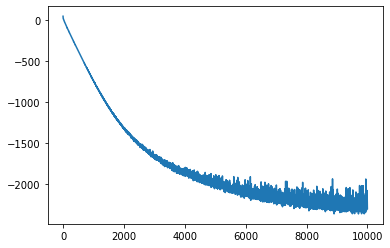

In [7]:
plt.plot(hist.history['loss'])

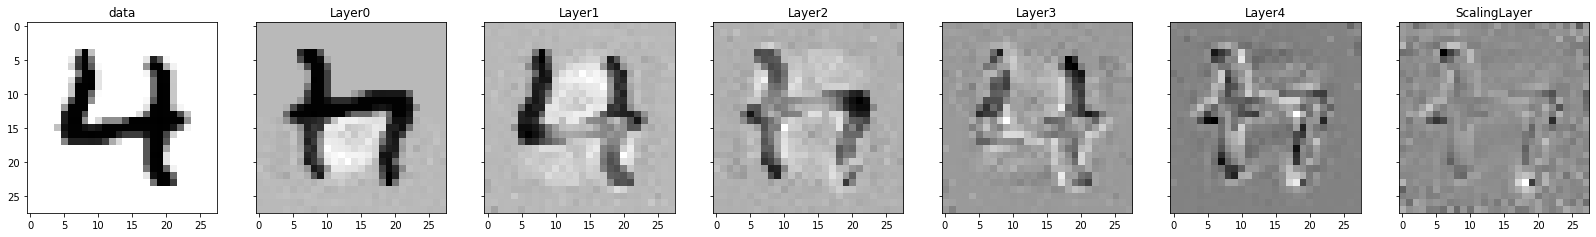

In [12]:
visualize_mnist_layers(model, dataset, direction='forward');

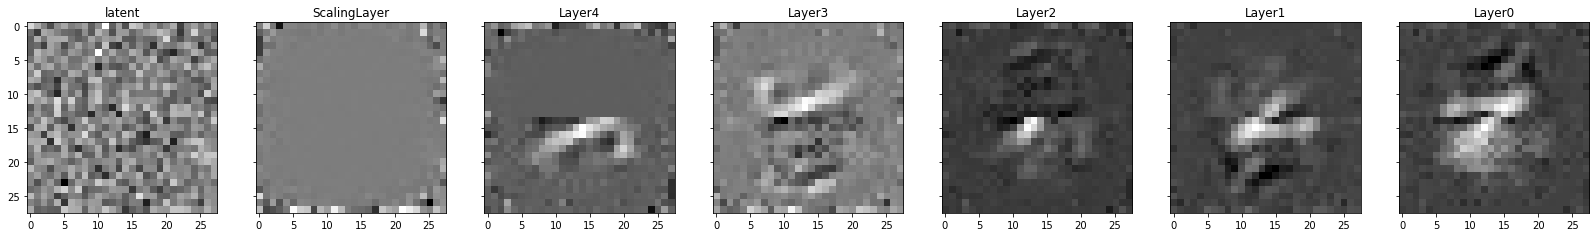

In [13]:
visualize_mnist_layers(model, dataset, direction='inverse');

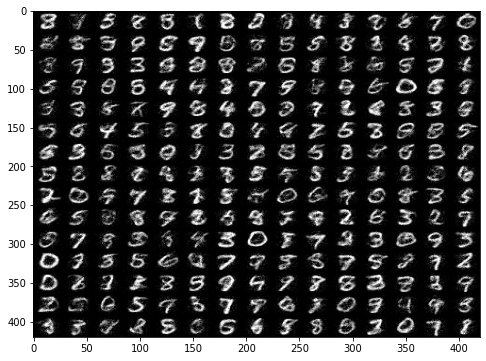

In [10]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
for i in range(n):
    for j in range(n):
        z_sample = np.random.randn(1, inp_dim).astype('float32') * 0.75 # std=.75 instead of 1
        x_decoded = model.inverse(z_sample).numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


figure = np.clip(figure*255, 0, 255)
fig, ax = plt.subplots(1, figsize=(8,6), facecolor='white')
ax.imshow(figure, aspect='auto', cmap='gray')

MovieWriter imagemagick unavailable; using Pillow instead.


result/nice_mnist.gif saved


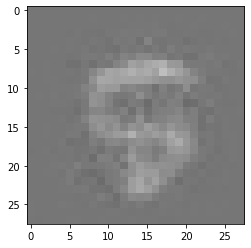

In [14]:
anim = animate_mnist_gif(model, filename='result/nice_mnist.gif')
HTML(anim.to_html5_video())